In [1]:
from modules.utils_data import load_data
from modules.plotting import plot_scatter_and_line
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import numpy as np

In [2]:
%%capture
# The previous line silences the output because I don't like it

# Load the data
df_combined = load_data()

In [3]:
# Split the train/test data
train, test = train_test_split(df_combined, test_size=0.3, random_state=42)
for col in df_combined.columns[1:]:
    print(f'{col}: {test[col].count()/df_combined[col].count()}')

LogVP: 0.3108348134991119
LogP: 0.303577830357783
LogOH: 0.3352601156069364
LogBCF: 0.27884615384615385
LogHalfLife: 0.37333333333333335
BP: 0.3094054849990797
Clint: 0.2783882783882784
FU: 0.29283489096573206
LogHL: 0.3199426111908178
LogKmHL: 0.28835489833641403
LogKOA: 0.32222222222222224
LogKOC: 0.32088520055325037
MP: 0.30270770654940987
LogMolar: 0.29888803680981596


In [4]:
# Subset the train data
fraction = 0.01
out_dir = 'LogP_low_data/'
os.makedirs(out_dir, exist_ok=True)

stl_test = test[["SMILES", "LogP"]].dropna()
stl_data = train[["SMILES", "LogP"]].dropna().sample(frac=1, random_state=42) # Shuffle data
other_properties = train.drop(columns="LogP")

os.makedirs(out_dir + 'STL', exist_ok=True)
stl_less_data = stl_data[:int(len(stl_data)*fraction)]
stl_less_data.to_csv(out_dir + 'STL/train.csv', index=False)
stl_test.to_csv(out_dir + 'STL/test.csv', index=False)
print("frac", fraction, ":", len(stl_less_data))   

os.makedirs(out_dir + 'MTL', exist_ok=True)
mtl_less_data = pd.merge(stl_less_data, other_properties, on="SMILES", how="outer")
mtl_less_data.to_csv(out_dir + 'MTL/train.csv', index=False)
test.to_csv(out_dir + 'MTL/test.csv', index=False)

property_list = mtl_less_data.drop(columns='SMILES').columns.to_list()

frac 0.01 : 97


In [5]:
# train STL
os.system(f'''chemprop train \
--data-path "{out_dir}STL/train.csv" \
--task-type regression \
--epochs 100 \
--output-dir "{out_dir}STL/model/" \
--num-workers 15 ''')

# Predict
os.system(f'''chemprop predict \
--test-path "{out_dir}STL/test.csv" \
--model-path "{out_dir}STL/model/model_0/best.pt" \
--preds-path "{out_dir}STL/preds.csv" \
--num-workers 15''')

# train MTL
os.system(f'''chemprop train \
--data-path "{out_dir}MTL/train.csv" \
--task-type regression \
--epochs 100 \
--target-columns {" ".join(property_list)} \
--task-weights {" ".join([str(10) if p != "LogP" else str(1) for p in property_list])} \
--output-dir "{out_dir}MTL/model/" \
--num-workers 15 ''')

# Predict
os.system(f'''chemprop predict \
--test-path "{out_dir}MTL/test.csv" \
--model-path "{out_dir}MTL/model/model_0/best.pt" \
--preds-path "{out_dir}MTL/preds.csv" \
--num-workers 15''')

Wrote config file to LogP_low_data/STL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/astartes/main.py:325: ImperfectSplittingWarning: Actual train/test split differs from requested size. Requested train size of 0.80, got 0.79. Requested validation size of 0.10, got 0.11. Requested test size of 0.10, got 0.11. 
  warn(
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 

Epoch 0: 100%|██████████| 2/2 [00:00<00:00, 16.38it/s, v_num=1, train_loss=0.819]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  5.40it/s, v_num=1, train_loss=0.349, val_loss=0.799]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  5.16it/s, v_num=1, train_loss=0.442, val_loss=0.790]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s, v_num=1, train_loss=0.278, val_loss=0.750]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  5.25it/s, v_num=1, train_loss=0.123, val_loss=0.723]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s, v_num=1, train_loss=0.409, val_loss=0.688]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 2/2 [00:00<00:00,  5.34it/s, v_num=1, train_loss=0.222, val_loss=0.676]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7:

`Trainer.fit` stopped: `max_epochs=100` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_low_data/STL/model/model_0/checkpoints/best-epoch=37-val_loss=0.15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_low_data/STL/model/model_0/checkpoints/best-epoch=37-val_loss=0.15.ckpt


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 311.73it/s]
Entire Test Set results: {'entire_test/mse': 3.2518705746415733}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 67/67 [00:00<00:00, 100.71it/s]
Wrote config file to LogP_low_data/MTL/model/config.toml


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A2000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For m

Epoch 0: 100%|██████████| 204/204 [00:01<00:00, 132.67it/s, v_num=1, train_loss=0.137]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 204/204 [00:01<00:00, 105.98it/s, v_num=1, train_loss=0.816, val_loss=0.428]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 204/204 [00:01<00:00, 112.72it/s, v_num=1, train_loss=0.311, val_loss=0.372]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 204/204 [00:01<00:00, 111.91it/s, v_num=1, train_loss=0.661, val_loss=0.423]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 204/204 [00:02<00:00, 97.62it/s, v_num=1, train_loss=0.276, val_loss=0.350] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 204/204 [00:02<00:00, 98.62it/s, v_num=1, train_loss=0.321, val_loss=0.354]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 204/204 [00:01<00:00, 104.98it/s, v_num=1, train_loss=0.277, val_loss=0.283]
Validation: |       

`Trainer.fit` stopped: `max_epochs=100` reached.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /localhome/eruijsena/Digital_Chemistry/LogP_low_data/MTL/model/model_0/checkpoints/best-epoch=57-val_loss=0.19.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /localhome/eruijsena/Digital_Chemistry/LogP_low_data/MTL/model/model_0/checkpoints/best-epoch=57-val_loss=0.19.ckpt


Predicting DataLoader 0: 100%|██████████| 26/26 [00:00<00:00, 379.84it/s]
Entire Test Set results: {'entire_test/mse': 941.5648821914964}


/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'output_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['output_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'graph_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['graph_transform'])`.
/localhome/eruijsena/.conda/envs/chemprop/lib/python3.11/site-

Predicting DataLoader 0: 100%|██████████| 109/109 [00:00<00:00, 144.07it/s]


0

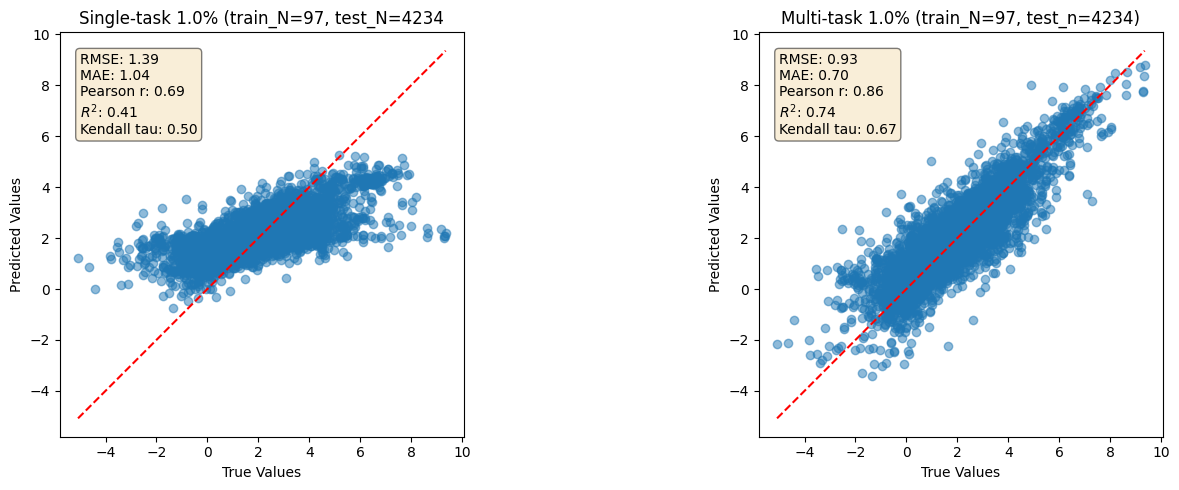

In [12]:
# Plotting results on OPERA test data

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs = axs.flatten()

# Prepare data for single-task
single_task_df = pd.read_csv(out_dir + 'STL/preds_0.csv')
valid_single = single_task_df[['SMILES', "LogP", 'pred_0']].dropna()
true_single_values = valid_single["LogP"]
pred_single_values = valid_single['pred_0']

# Prepare data for multi-task
multi_task_df = pd.read_csv(out_dir + 'MTL/preds_0.csv')
valid_multi = multi_task_df[['SMILES', "LogP", 'pred_0']].dropna()
true_multi_values = valid_multi["LogP"]
pred_multi_values = valid_multi['pred_0']

# Plotting single-task
plot_scatter_and_line(axs[0], true_single_values, pred_single_values, f'Single-task {fraction*100}% (train_N={len(stl_less_data)}, test_N={len(valid_single)}')

# Plotting multi-task
plot_scatter_and_line(axs[1], true_multi_values, pred_multi_values, f'Multi-task {fraction*100}% (train_N={len(mtl_less_data["LogP"].dropna())}, test_N={len(valid_multi)})')

plt.tight_layout()
plt.show()